This notebook contains the solution to the problem of key value extraction from scanned receipts. The goal is to detect values of the following items for a set of images of receipts: (1) Comapny, (2) Date and (3) Total. This is a key value extraction problem that can be modeled as a sequence labelling problem.

Below are the steps adopted in order to solve this problem:

1. Obtain a dataset of receipts with gold annotations of 
key/value pairs that need to be extracted. I found the dataset [here](https://drive.google.com/drive/folders/1ShItNWXyiY1tFDM5W02bceHuJjyeeJl2). The dataset was published by [ICDAR 2019 Robust Reading Challenge on Scanned Receipts OCR and Information Extraction](https://rrc.cvc.uab.es/?ch=13). This challenge aims to tackle both OCR and information extraction from receipts. Dataset provided contains a gold dataset of the tokens extracted from receipts as well as key value pairs for company, date, total, and address. In this notebook, the goal is to extract the first three items.
2. For OCR, I use python tesseract library to extract text from recipts. 
3. Gold annotations are mapped to the text in order to create gold dataset. This mapping might not work perfectly however in the presence of OCR errors in the text extracted from an image. This means that some text segments that should be labeled are not labeled and might affect final result. Ideally, this needs to be handled but it is skipped in this solution.
4. The dataset is split into train and test sets. A 60/20/20 split is chosen since the size of the dataset is not very large and in order to have a test set of reasonable size.
5. A BERTForTokenClassification model is used for labeling tokens with company, date or total labels.
6. Results on both train and test set are reported to detect whether the model is underfitting or overfitting the data.

In the presence of more time for experiments, I would try the following to improve results:

1. A different OCR library like PaddleOCR. Tesseract seems to produce noisy text in some cases as will be shown below.
3. Different values for model hyperparameters need to be tested to find the best values that will produce best results.
4. An appropriate technique to select one item if multiple items were extracted. Sometimes two values are identified as a total, but only one of them needs to be considered the total of the receipt. One simple solution can be to select the larger value.

Now let's start implementing the solution.

First, tesseract libraries and seqeval library need to be installed.

In [ ]:
!apt install tesseract-ocr
!apt install libtesseract-dev
!pip install Pillow
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [ ]:
!pip install transformers seqeval[gpu]

     |████████████████████████████████| 3.5 MB 5.6 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 895 kB 28.4 MB/s 
     |████████████████████████████████| 67 kB 3.7 MB/s 
     |████████████████████████████████| 6.8 MB 29.0 MB/s 
     |████████████████████████████████| 596 kB 33.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=6315ed595eb6c99de617b779b7e202611bb75fccf5dbcfce51117a5117ec7881
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Import all necessary libraries.

In [ ]:
import nltk
nltk.download('punkt')
from PIL import Image
import pytesseract
from nltk.tokenize import word_tokenize
from os import walk
from pathlib import Path
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
import IPython

from seqeval.metrics import classification_report
from transformers import BertTokenizer, BertModel, BertTokenizerFast, BertConfig, BertForTokenClassification
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
import torch

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Read images from folder, convert each to text using pytesseract, and map annotations to text for each receipt. In the following code snippet, I comment the line extracting text from images since I performed that step once and stored output in text files. For faster experiments, I load text directly from files.

BIO annotation scheme is used to map annotation to text. For instance, if the following is the name of a company: "DE LUXE CIRCLE FRESH MART SDN BHD", the first token will be labeled with B-company, and all remaining tokens will be labeled with I-company.

In [ ]:
path = "/content/drive/MyDrive/0325updated.task2train(626p)/"
# Pattern for annotations: "label": "labeled segment"
annotation_pattern = re.compile("\"(company|date|total)\"\:\s\"(.+)\"")
# Store sentences and tags
sentences = []
tags = []
source_files = []
# Traverse directory of train text files and images
for (dirpath, dirnames, filenames) in walk(path):  
  for file_name in filenames:
    if file_name.endswith(".jpg"):
      txt_file = file_name.replace(".jpg", ".txt")
      if Path(dirpath+txt_file).is_file():
        # Extract text from image
        #file_string = pytesseract.image_to_string(Image.open(dirpath+file_name))
        #with open(dirpath+txt_file+".txt", "w") as text_file:
          #text_file.write(file_string)
        with open(dirpath+txt_file+".txt") as text_file:
          file_string = text_file.read()
        # Read annotations
        with open(dirpath+txt_file) as annotations:
          for line in annotations:
            for (label, segment) in re.findall(annotation_pattern, line):
              prefix = " I-"+label+"-"
              new_segment = prefix.join(segment.split())
              new_segment = prefix.replace("I-","B-") + new_segment.lstrip()
              # assume that each segment will appear once
              if segment in file_string:
                file_string = file_string.replace(segment, new_segment)
        file_lines = file_string.splitlines()
        file_lines = [word_tokenize(line) for line in file_lines if line.strip()]
        sentences.extend([re.sub("(B|I)\-(company|date|total)\-", "", word).lower() for word in line] for line in file_lines)
        tags.extend([["O" if not re.match("(B|I)\-(company|date|total)\-.+", word) else "-".join(word.split("-")[0:2]) for word in line] for line in file_lines])
        source_files.extend([txt_file for i in range(len(file_lines))])

The number of occurrences of each tag is counted. Idate has very few occurrences so it is displayed to check why there are some Idate instances.

In [ ]:
count_tags = Counter(tag for tag_sequence in tags for tag in tag_sequence)
print(count_tags)
print(len(source_files), len(sentences))

Counter({'O': 102676, 'B-total': 968, 'I-company': 864, 'B-date': 585, 'B-company': 315, 'I-total': 18, 'I-date': 2})
21131 21131


In the next cell I print sentences containing "Idate" tag to take a closer to segments assigned this tag. I do this since the frequency of the tag is only two so I need to double check that annotations are correct.

In [ ]:
for index, sentence_tags in enumerate(tags):
  if "Idate" in sentence_tags:
    print(source_files[index], sentences[index], tags[index])

Counts are plotted, once with "Other" tag and once without it. Normally we would not care about segments labeled as other since they are not of interest. We are interested in extracting tokens assigned other labels. In addition, other class is usually the dominant class and the model will likely not have any problem identifying the dominant class.

<BarContainer object of 6 artists>

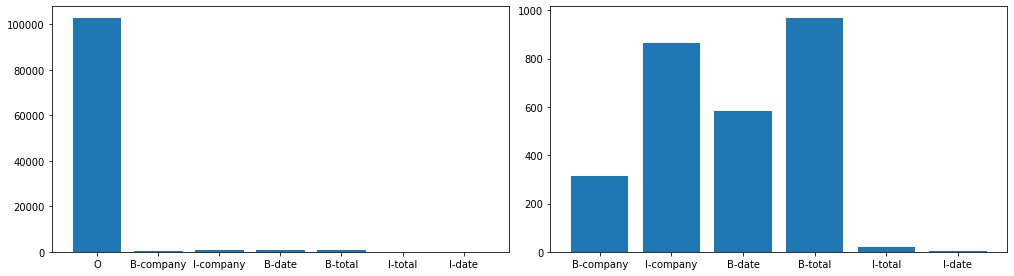

In [ ]:
count_tags_no_other = Counter(tag for tag_sequence in tags for tag in tag_sequence if tag!="O")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
fig.tight_layout()
ax1.bar(count_tags.keys(), count_tags.values())
ax2.bar(count_tags_no_other.keys(), count_tags_no_other.values())

A histogram is plotted for sentence lengths and lenghts are almost normally distributed.

I obtain maximum sentence length to pad shorter sentences and make lengths of all sentences the same. 10 is added to the maximum length to be able to handle longer sentences that might appear in the unseen test set.

Number of sentences is: 21,131. Maximum sentence length is 45


(array([1.197e+03, 2.157e+03, 3.421e+03, 3.556e+03, 3.091e+03, 2.555e+03,
        1.942e+03, 1.285e+03, 7.780e+02, 4.660e+02, 3.160e+02, 2.130e+02,
        4.400e+01, 1.900e+01, 1.800e+01, 1.000e+01, 3.000e+00, 3.000e+00,
        7.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 2.000e+00,
        3.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 4.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00]),
 array([ 1.        ,  1.97777778,  2.95555556,  3.93333333,  4.91111111,
         5.88888889,  6.86666667,  7.84444444,  8.82222222,  9.8       ,
        10.77777778, 11.75555556, 12.73333333, 13.71111111, 14.68888889,
        15.66666667, 16.64444444, 17.62222222, 18.6       , 19.57777778,
        20.55555556, 21.53333333, 22.51111111, 23.48888889, 24.46666667,
        25.44444444, 26.42222222, 27.4       , 28.37777778, 29.35555556,
 

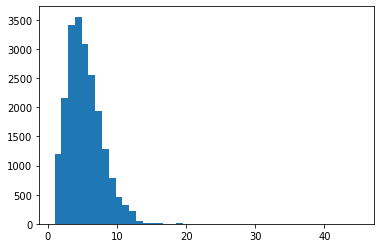

In [ ]:
sent_lengths = [len(sentence) for sentence in sentences]
max_length = max(sent_lengths)
print("Number of sentences is: {:,}. Maximum sentence length is {}".format(len(sentences), max_length))
max_length += 10
plt.hist(sent_lengths, bins=45)

Investigate the longest sentence. Since the sentence looks weird, I display the source image and the text to make sure why it looks strange. It turns out that tesseract produces a set of meaningless characters when it encounters lines in the receipt. This is obviously something that needs to be handled to remove noise from the dataset used in training. In this notebook, I ignore this issue for now and proceed with tesseract output.

In [ ]:
for index, sentence in enumerate(sentences):
  if len(sentence) == max_length-10:
    print(sentence)
    print(source_files[index])

['eae', 'cme', 'erent', 'cere', 'ees', 'rh', 'se', 'es', 'sens', 'renan', 'ore', 'cami', 'ene', ':', 'hm', 'ema', 'came', '”', 'eet', 'eons', 'aree', 'wnahae', 'amen', 'seon', 'et', 'ae', 'pam', 'entre', 'md', 'gar', 'mm', 'cen', 'se', '6', ':', '+m', 'ere', '©', 'me', 'em', 'ere', 'es', 'sn', ',', 'sry']
X51007846393.txt


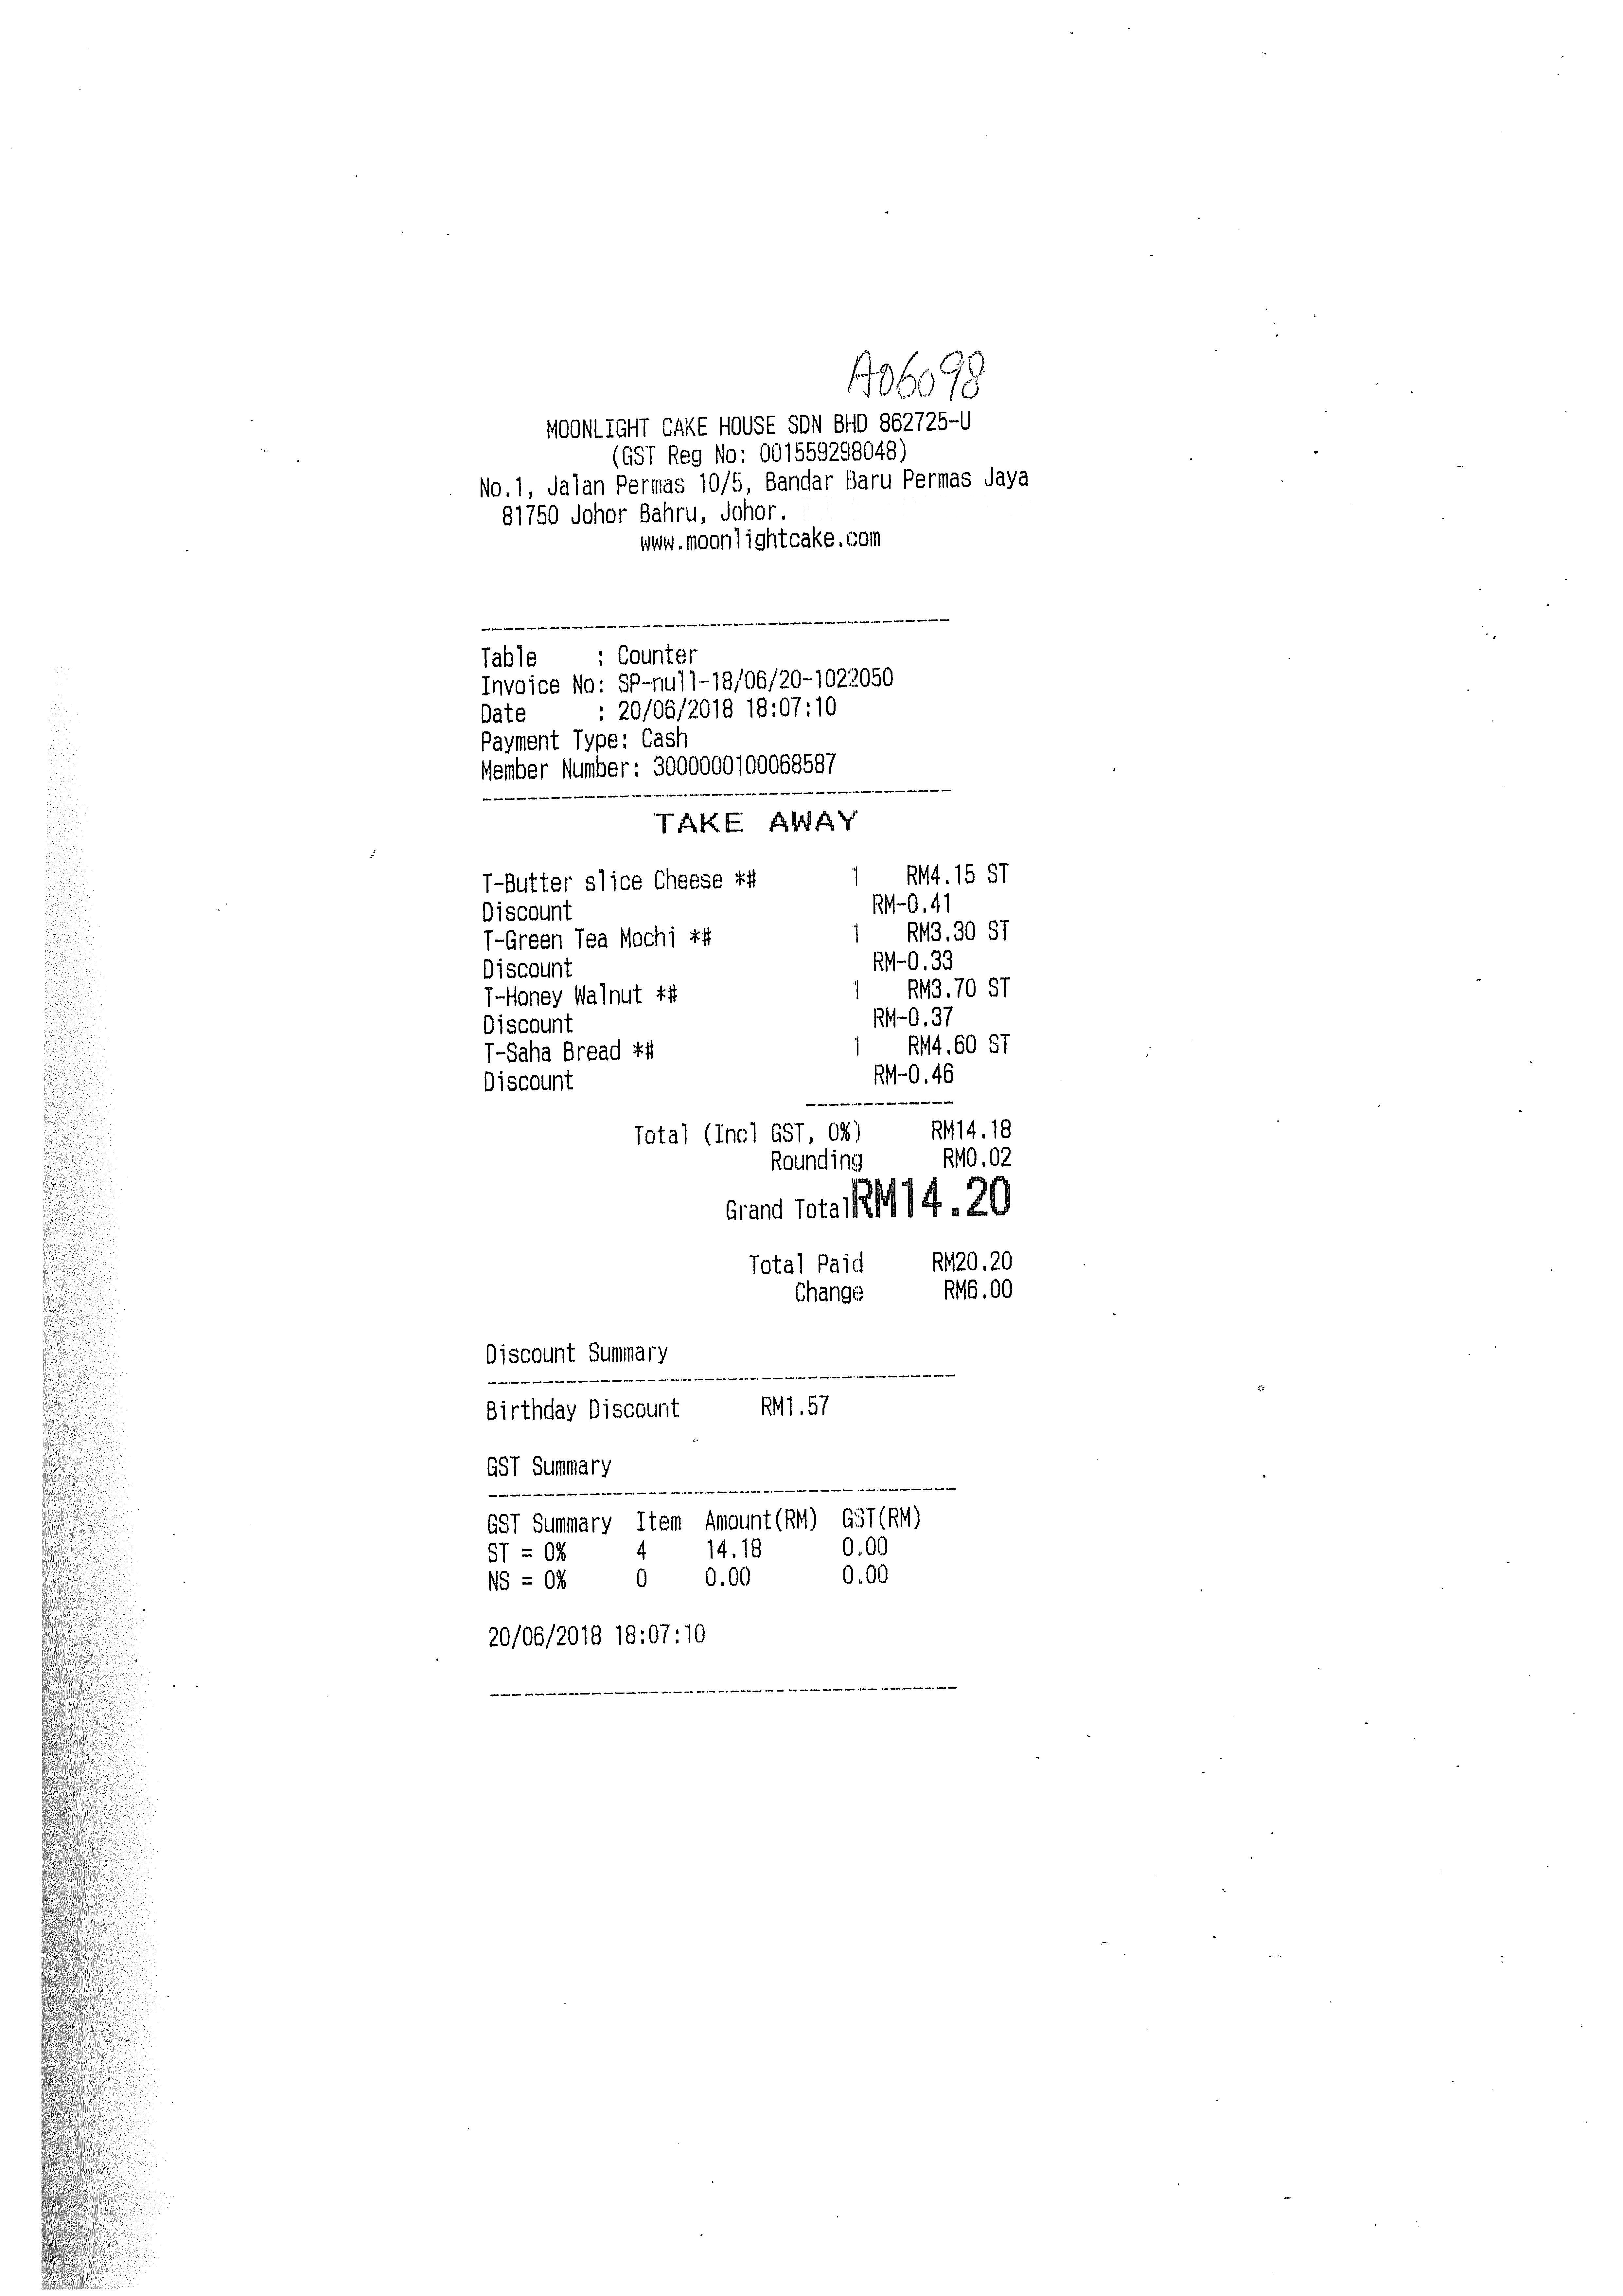

In [ ]:
IPython.display.Image(dirpath+"X51007846393.jpg")

In [ ]:
#file_string = pytesseract.image_to_string(Image.open(dirpath+"X51007846393.jpg"))
with open(dirpath+"X51007846393.txt.txt") as text_file:
  print(text_file.read())

 

Kabo98

MOONLIGHT CAKE HOUSE SDN BHD 862725-U
(GST Reg No: 001559258048)
No.1, Jalan Permas 10/5, Bandar Baru Permas Jaya
91750 Johor Bahru, Johor.
uwil.moonlightcake. com

ere foes tee come nan etme Sih eine em te MAD gure oun seman cute serty mem cance “ec bane Me pe pe en teem cee ee raat me se Hat emt 9 a Some nee ean erat emer mee SOY

Table + Counter
Invoice No: Sp- hal 18/06/20-1022050
Date » 20/06/2018 18:07:10

Payment Type: Cas h
Member Number: 3000000100068587

eae cme erent cere ees rh Se es Sens Renan ORE cami ene: Hm ema came” eet eons Aree wnahae amen Seon et ae pam entre md Gar mm cen Se 6: +m ERE © me em ere eS SN, SRY

TAKE AWAY
T-Butter slice Cheese *# 1} RM4.15 ST
Discount RM-0,41
T-Green Tea Mochi *# | RM3.30 ST
Discount RM-0.33
T-Honey Walnut #*# | -RM3.70 ST
Discount RM-0.37
T-Saha Bread ¥4# 1  RM4,.60 ST
Discount RM-0.46
Total (Incl GST, 0%) RM14.18
Rounding RMO .02

rand Total eM 14.20

Total Paid RM20.20
Change RM6 .00

Discount Summary

arms cae tener ween

Create list of vocabulary and print its size.

Create tag2index and index2tag dictionary.

In [ ]:
tag2index = {tag:index for index, tag in enumerate(list(count_tags.keys()))} # create an index for each tag in the dataset
# create reverse dictionaries to be able to retrieve a tag from an index and a word from an index after testing.
index2tag = {index:tag for tag, index in tag2index.items()}
# get the total number of words in the dataset (vocabulary) as well as the total number of tags in the dataset.
tags_count = len(tag2index)
print("Total number of unique of tags: {}".format(len(tag2index)))

Total number of unique of tags: 7


In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
data_dic = {"Sentence":sentences, "Tags":tags}
train_df = pd.DataFrame(data_dic)
display(train_df.head(17))

,Sentence,Tags
0,"[—, oe, oe]","[O, O, O]"
1,"[restoran, de, coffee, o]","[B-company, I-company, I-company, I-company]"
2,"[no, 33, ,, 35, ,, g, f, jalan, temenggung, 3/...","[O, O, O, O, O, O, O, O, O, O, O]"
3,"[bandar, mahkota, cheras, ,]","[O, O, O, O]"
4,"[43200, cheras, ,, selangor, |]","[O, O, O, O, O]"
5,"[gst, no, ,, ;, 002062008320]","[O, O, O, O, O]"
6,"[tax, invoice]","[O, O]"
7,"[‘, receipt, #, cso0119810, —_—datte, 03/04/2018]","[O, O, O, O, O, B-date]"
8,"[time, :, __, 12:32:00, a]","[O, O, O, O, O]"
9,"[(, gst, ), (, gst, )]","[O, O, O, O, O, O]"


In [ ]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        sentence = self.data.Sentence[index]  
        tags = self.data.Tags[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        tags = [tag2index[label] for label in tags] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_tags = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_tags[idx] = tags[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['Tags'] = torch.as_tensor(encoded_tags)
        
        return item

  def __len__(self):
        return self.len

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 5
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10

In [ ]:
train_size = 0.8
train_dataset = train_df.sample(frac=train_size,random_state=200)
test_dataset = train_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(train_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (21131, 2)
TRAIN Dataset: (16905, 2)
TEST Dataset: (4226, 2)


In [ ]:
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["input_ids"]), training_set[0]["Tags"]):
  print('{0:10}  {1}'.format(token, label))

[CLS]       -100
thank       0
you         0
.           0
[SEP]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD] 

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(tag2index))
model.to(device)

cuda


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
tags = inputs["Tags"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
tags = tags.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=tags)
initial_loss = outputs[0]
initial_loss

tensor(2.0527, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 7])

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['Tags'].to(device, dtype = torch.long)

        model_out = model(input_ids=ids, attention_mask=mask, labels=labels)
        loss = model_out[0]
        tr_logits = model_out[1]
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 100 training steps: 2.126800060272217
Training loss per 100 training steps: 0.3683613402455455
Training loss per 100 training steps: 0.24881497927621674
Training loss per 100 training steps: 0.20741554297834783
Training loss per 100 training steps: 0.17798854613634862
Training loss per 100 training steps: 0.16206345954880177
Training loss per 100 training steps: 0.1486566870085145
Training loss per 100 training steps: 0.13668000091168864
Training loss per 100 training steps: 0.12637594937795676
Training loss per 100 training steps: 0.1182669425905464
Training loss per 100 training steps: 0.11311533015449769
Training loss per 100 training steps: 0.10697953231460572
Training loss per 100 training steps: 0.10314557463352139
Training loss per 100 training steps: 0.10055002053021285
Training loss per 100 training steps: 0.09789801514169054
Training loss per 100 training steps: 0.09546155488789565
Training loss per 100 training steps: 0.0930629261291768
Tr

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['Tags'].to(device, dtype = torch.long)
            
            model_out = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss = model_out[0]
            eval_logits = model_out[1]
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [[index2tag[id.item()] for id in eval_labels]]
    predictions = [[index2tag[id.item()] for id in eval_preds]]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.0001546762214275077
Validation loss per 100 evaluation steps: 0.025349286821870234
Validation loss per 100 evaluation steps: 0.03318213436479474
Validation loss per 100 evaluation steps: 0.04849963019924899
Validation loss per 100 evaluation steps: 0.05825649046654374
Validation loss per 100 evaluation steps: 0.05604541176774704
Validation loss per 100 evaluation steps: 0.06392963306883358
Validation loss per 100 evaluation steps: 0.07094415674318966
Validation loss per 100 evaluation steps: 0.06693094845968346
Validation loss per 100 evaluation steps: 0.06430138658445207
Validation loss per 100 evaluation steps: 0.05974983836502353
Validation loss per 100 evaluation steps: 0.057413404017207355
Validation loss per 100 evaluation steps: 0.060097491645346786
Validation loss per 100 evaluation steps: 0.05847311607329812
Validation loss per 100 evaluation steps: 0.05603047298610882
Validation loss per 100 evaluation steps: 0.059108887523952644
Va

In [ ]:
print(len(labels), len(predictions))
print(classification_report(labels, predictions))

1 1
              precision    recall  f1-score   support

     company       0.85      0.68      0.75        93
        date       0.92      0.81      0.86       108
       total       0.75      0.65      0.70       214

   micro avg       0.82      0.70      0.75       415
   macro avg       0.84      0.72      0.77       415
weighted avg       0.82      0.70      0.75       415



References

https://medium.com/one9-tech/information-extraction-receipt-ocr-scan-deep-learning-1e68ce5a9ae7

https://www.coursera.org/specializations/deep-learning

https://blog.dominodatalab.com/named-entity-recognition-ner-challenges-and-model

https://pandas.pydata.org

https://scikit-learn.org/

https://github.com/keras-team/keras-contrib

https://stackoverflow.com/

Deep learning with python. https://www.manning.com/books/deep-learning-with-python